In [109]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from ultralytics import YOLO
from utils import *
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display


plt.rcParams["figure.figsize"] = (5,5)

In [110]:
img_path = 'C:/Users/Duong/Downloads/test.jpg'

In [111]:
LP_model = YOLO('C:/Users/Duong/PycharmProjects/re_plate/yolov8/train1/weights/best.pt')

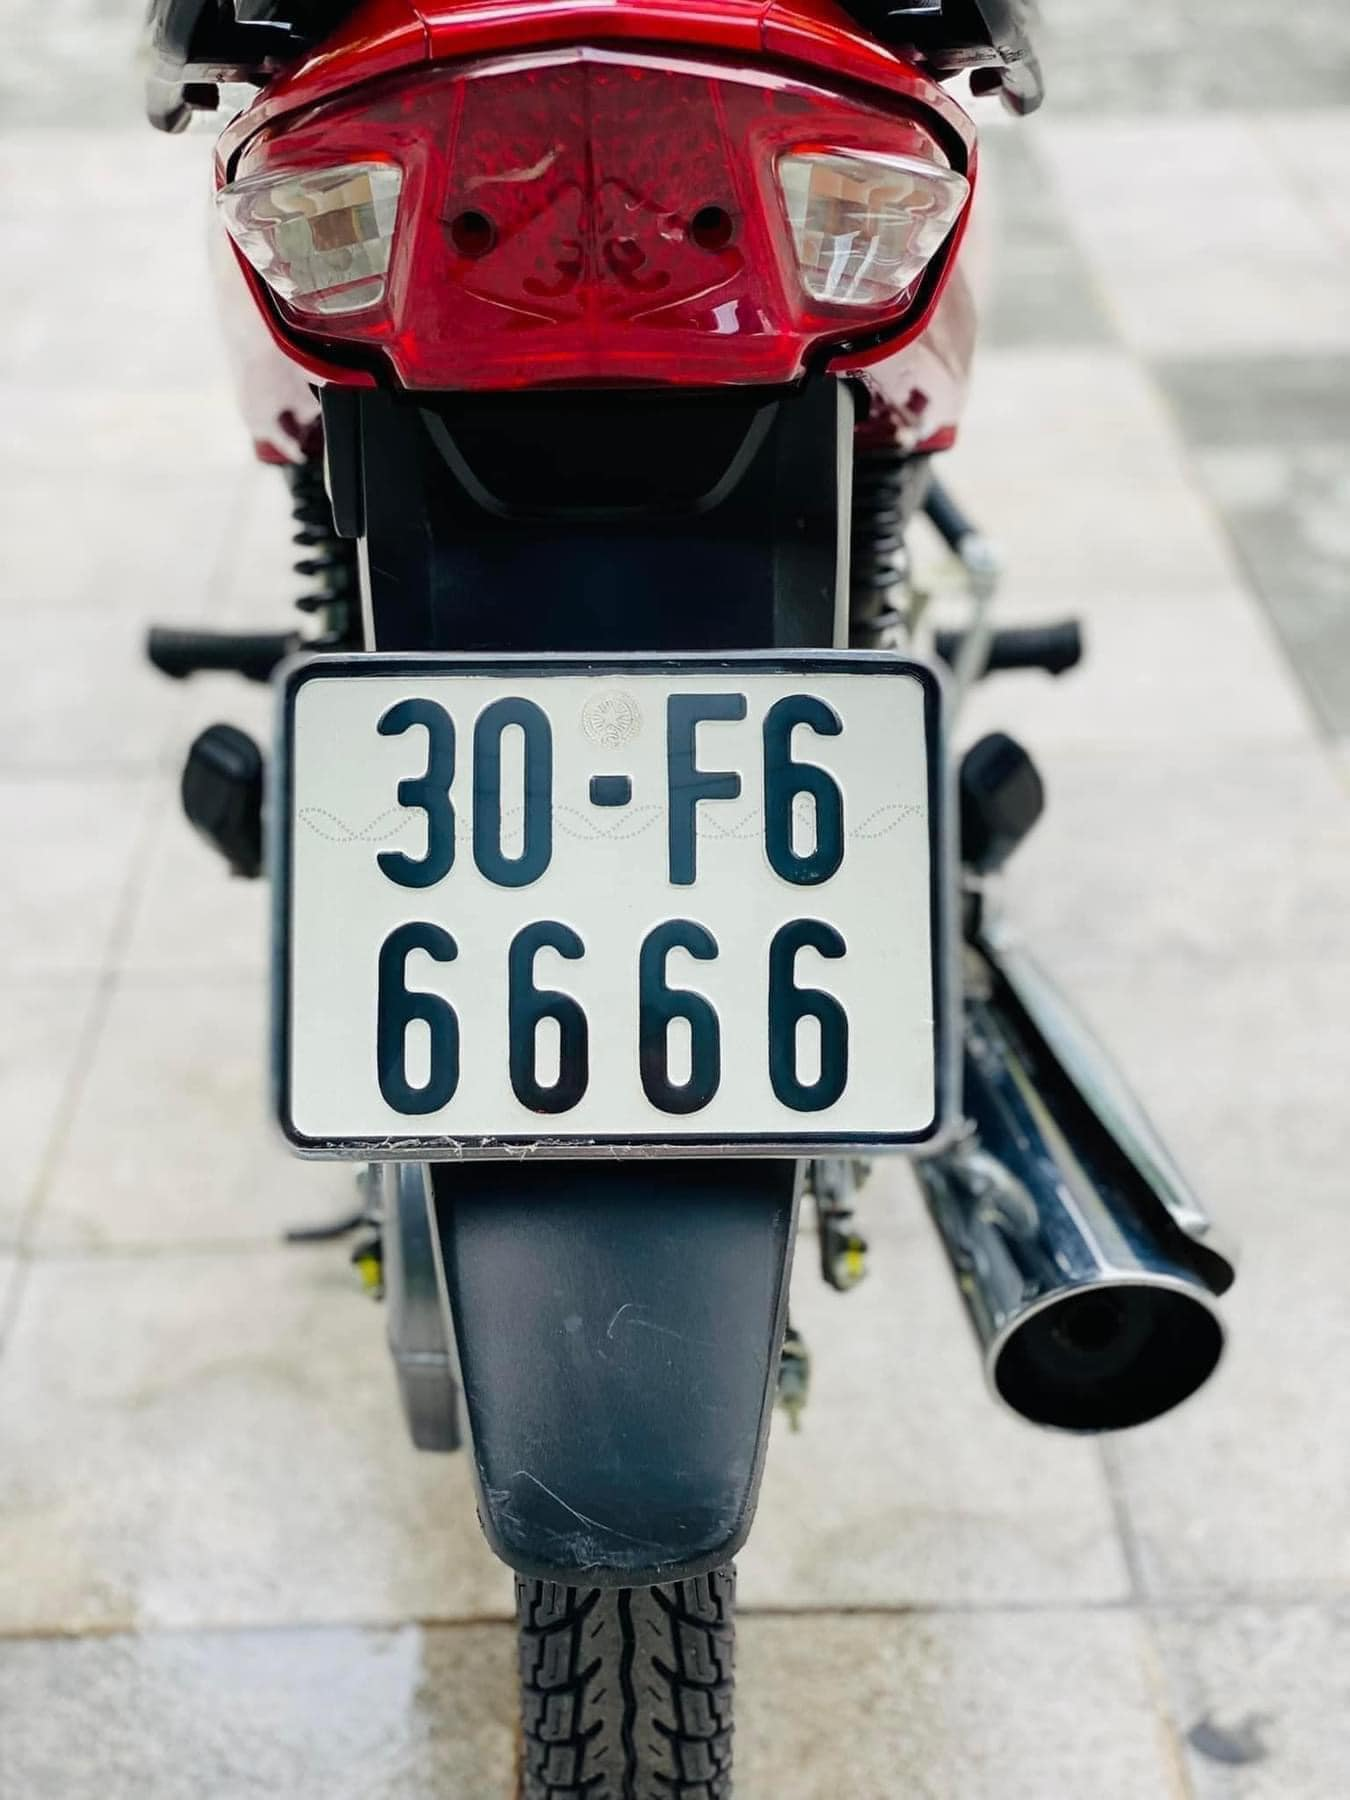

In [112]:
in_img = cv2.imread(img_path)
in_img = cv2.cvtColor(in_img, cv2.COLOR_BGR2RGB)
in_img1 = Image.fromarray(in_img)
display(in_img1)

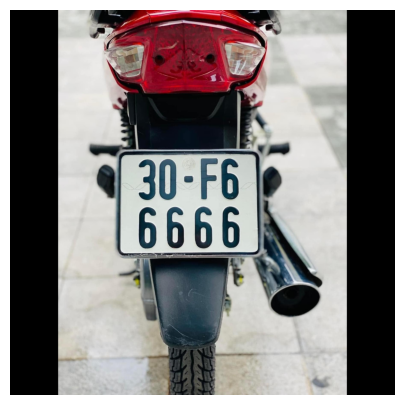

In [113]:
in_img = fit_to_square(in_img, size=max(in_img.shape[:2]))
plt.imshow(in_img)
plt.axis('off')  # Hide axes
plt.show()

In [114]:
results = LP_model.predict(in_img)
print(results)


0: 640x640 1 Plate, 321.0ms
Speed: 9.3ms preprocess, 321.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'Plate'}
obb: None
orig_img: array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
 

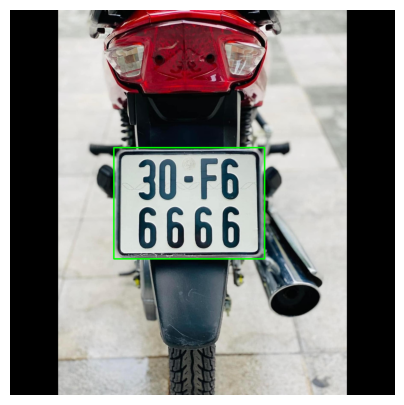

In [115]:
ROIs = []

# Ngưỡng độ tin cậy
CONFI_THRES = 0.7

# Lấy thông tin hộp giới hạn từ kết quả YOLOv8
for result in results:
    boxes = result.boxes.data.tolist()
    for box in boxes:
        x_min, y_min, x_max, y_max, confidence, cls = box
        if confidence > CONFI_THRES:
            x_min, y_min, x_max, y_max = map(int, [x_min, y_min, x_max, y_max])
            # Cắt vùng ROI từ hình ảnh gốc
            roi = in_img[y_min:y_max, x_min:x_max]
            ROIs.append(roi)
            # Draw the bounding box
            cv2.rectangle(in_img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 5)
# Display the image with bounding boxes
plt.imshow(in_img)
plt.axis('off')
plt.show()

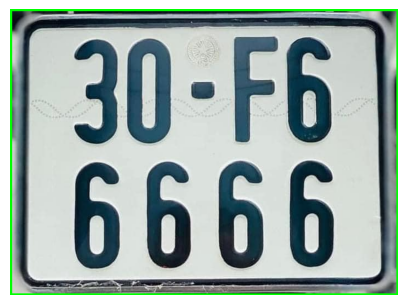

In [116]:
plt.imshow(ROIs[0])
plt.axis('off')  
plt.show()

# Character detect

In [117]:
char_det_model = YOLO('C:/Users/Duong/PycharmProjects/re_plate/yolov8/train_char_location/weights/best.pt')

In [118]:
img_lp = ROIs[0]

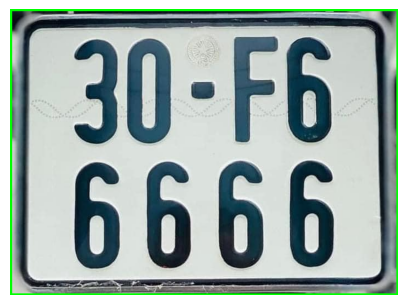

In [119]:
plt.imshow(img_lp)
plt.axis('off')  
plt.show()

In [120]:
results = char_det_model.predict(img_lp)


0: 480x640 8 Chars, 195.5ms
Speed: 4.0ms preprocess, 195.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


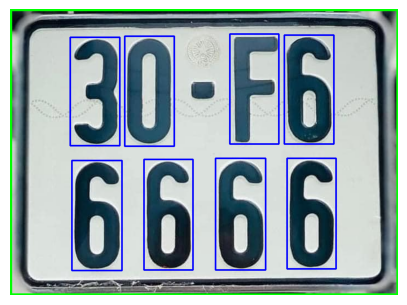

In [121]:
import cv2

CHAR_THRES = 0.7

chars = []
char_centers = []

for result in results:
    boxes = result.boxes.data.tolist()
    for box in boxes:
        x_min, y_min, x_max, y_max, confidence, cls = box
        if confidence > CHAR_THRES:
            x_min, y_min, x_max, y_max = map(int, [x_min, y_min, x_max, y_max])
            # Cắt vùng ROI từ hình ảnh gốc
            char = img_lp[y_min:y_max, x_min:x_max]
            char = cv2.cvtColor(char, cv2.COLOR_BGR2GRAY)
            char = resize_with_ratio(char, 28/char.shape[0])
            border = 28-char.shape[1]
            if border % 2 == 0:
                border_L = border_R = border // 2
            else:
                border_L = border // 2
                border_R = border_L + 1
            char = cv2.copyMakeBorder(char, 0, 0, border_L, border_R, cv2.BORDER_REPLICATE)
            chars.append(char)
            # Tính tọa độ trung tâm của bounding box
            center_x = (x_min + x_max) // 2
            center_y = (y_min + y_max) // 2
            char_centers.append((center_x, center_y))  
            # Vẽ bounding box
            cv2.rectangle(img_lp, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)

# Hiển thị hình ảnh với bounding boxes
plt.imshow(img_lp)
plt.axis('off')
plt.show()

In [122]:
for i, center in enumerate(char_centers):
    bbox = chars[i]
    print("Bounding box {}: Tọa độ trung tâm: ({}, {})".format(i+1, center[0], center[1]))


image = Image.fromarray(chars[5])
display(image)

Bounding box 1: Tọa độ trung tâm: (253, 149)
Bounding box 2: Tọa độ trung tâm: (287, 373)
Bounding box 3: Tọa độ trung tâm: (543, 146)
Bounding box 4: Tọa độ trung tâm: (157, 375)
Bounding box 5: Tọa độ trung tâm: (418, 372)
Bounding box 6: Tọa độ trung tâm: (547, 371)
Bounding box 7: Tọa độ trung tâm: (154, 149)
Bounding box 8: Tọa độ trung tâm: (443, 145)


# Character recognize

In [123]:
ALPHA_DICT = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
    10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'K', 19: 'L',
    20: 'M', 21: 'N', 22: 'P', 23: 'R', 24: 'S', 25: 'T', 26: 'U', 27: 'V', 28: 'X', 29: 'Y', 30: 'Z'}

In [124]:
from keras.layers import Input

# Khai báo input shape
input_shape = (28, 28, 1)

# Khai báo model
reco_model = Sequential()

# Thêm lớp Input
reco_model.add(Input(shape=input_shape))

# Thêm các lớp Convolutional, BatchNormalization và MaxPooling
reco_model.add(Conv2D(64, (5, 5), padding='same', activation='relu'))
reco_model.add(BatchNormalization())
reco_model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
reco_model.add(BatchNormalization())
reco_model.add(MaxPooling2D(pool_size=(2, 2)))

reco_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
reco_model.add(BatchNormalization())
reco_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
reco_model.add(BatchNormalization())
reco_model.add(MaxPooling2D(pool_size=(2, 2)))

reco_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
reco_model.add(BatchNormalization())
reco_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
reco_model.add(BatchNormalization())
reco_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
reco_model.add(BatchNormalization())
reco_model.add(MaxPooling2D(pool_size=(2, 2)))

reco_model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
reco_model.add(BatchNormalization())
reco_model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
reco_model.add(BatchNormalization())
reco_model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
reco_model.add(BatchNormalization())
reco_model.add(MaxPooling2D(pool_size=(2, 2)))

# Thêm lớp Flatten và các lớp Dense
reco_model.add(Flatten())
reco_model.add(Dense(1024, activation='relu'))
reco_model.add(Dropout(0.5))
reco_model.add(Dense(31, activation='softmax'))

In [125]:
reco_model.load_weights('C:/Users/Duong/PycharmProjects/re_plate/CNN/char_classification/char_reco.h5')

In [126]:
char_tensor = np.array(chars).reshape((len(chars), 28, 28, 1))
char_tensor = char_tensor / 255.0

In [127]:
result = reco_model.predict(char_tensor)
result = np.argmax(result, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


In [128]:
chars = [ALPHA_DICT[i] for i in result]

In [129]:
def format_LP(chars, char_centers):
    x = [c[0] for c in char_centers]
    y = [c[1] for c in char_centers]
    y_mean = np.mean(y)

    if y_mean - min(y) < 0.1:
        return [i for _, i in sorted(zip(x, chars))]
    
    sorted_chars = [i for _, i in sorted(zip(x, chars))]
    y = [i for _, i in sorted(zip(x, y))]
    first_line = [i for i in range(len(chars)) if y[i] < y_mean]
    second_line = [i for i in range(len(chars)) if y[i] > y_mean]
    return [sorted_chars[i] for i in first_line] + ['-'] + [sorted_chars[i] for i in second_line]

In [130]:
final_lab = ''.join(format_LP(chars, char_centers))

# Result

30F6-6666


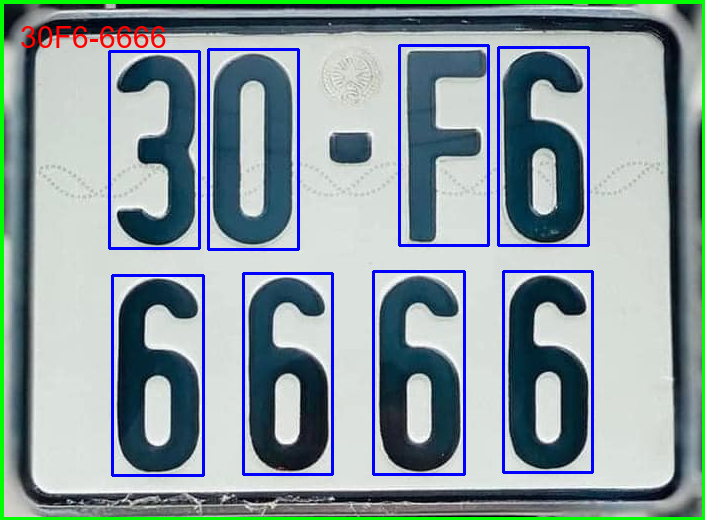

In [131]:
result = Image.fromarray(ROIs[0])
# Tạo một đối tượng vẽ để vẽ ký tự lên ảnh
draw = ImageDraw.Draw(result)

# Định nghĩa font và kích thước của nó
font = ImageFont.truetype("arial.ttf", 30)

# Vẽ chuỗi ký tự lên ảnh
draw.text((20, 20), final_lab, fill=(255, 0, 0), font=font)

# Hiển thị ảnh
print(final_lab)
display(result)